In [11]:
# pip install PyAudioWPatch

from scipy.signal import resample
import pyaudiowpatch as pyaudio
import time
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import os
import scipy.io.wavfile as wavfile

def save_wave(audio_frames,rate):
    # Scale back to 16-bit PCM format for saving
    audio_normalized = (audio_frames * 32767).astype(np.int16)
    # Save the normalized audio to a WAV file
    wav_file = f"temp_audio.wav"
    wavfile.write(wav_file, rate, audio_normalized)



### To use the output from the speakers, there is no stright way. We have to create a virtual "microphone" which will "loop back" the speake's output as input.

```pyaudiowpatch``` It is a nice library, that helps us loop-back the output from window's speaker as input. But it only works with WINDOWS for now. Also, even using this not that strightforward and you will have to tweak some parameters according to your system.

Here are some steps to select the right speaker:

- First get the list of speakers and micro_phones available.
- look for ```isLoopbackDevice``` parameter in the list. If this is ```True``` for loopback devices then that speaker can be selected as microphone.
- Then you have to note the ```index``` of these loopback devices and try manually to select the right speaker. (For how to test the loopback devices, see next section below)

In [2]:
p = pyaudio.PyAudio()

print('These are all the available speakers and microphones\n')

for idx in range(p.get_device_count()):
    print(p.get_device_info_by_index(idx))


These are all the available speakers and microphones

{'index': 0, 'structVersion': 2, 'name': 'Microsoft Sound Mapper - Input', 'hostApi': 0, 'maxInputChannels': 2, 'maxOutputChannels': 0, 'defaultLowInputLatency': 0.09, 'defaultLowOutputLatency': 0.09, 'defaultHighInputLatency': 0.18, 'defaultHighOutputLatency': 0.18, 'defaultSampleRate': 44100.0, 'isLoopbackDevice': False}
{'index': 1, 'structVersion': 2, 'name': 'Microphone (Realtek High Defini', 'hostApi': 0, 'maxInputChannels': 2, 'maxOutputChannels': 0, 'defaultLowInputLatency': 0.09, 'defaultLowOutputLatency': 0.09, 'defaultHighInputLatency': 0.18, 'defaultHighOutputLatency': 0.18, 'defaultSampleRate': 44100.0, 'isLoopbackDevice': False}
{'index': 2, 'structVersion': 2, 'name': 'Stereo Mix (Realtek High Defini', 'hostApi': 0, 'maxInputChannels': 2, 'maxOutputChannels': 0, 'defaultLowInputLatency': 0.09, 'defaultLowOutputLatency': 0.09, 'defaultHighInputLatency': 0.18, 'defaultHighOutputLatency': 0.18, 'defaultSampleRate': 44100

### In this case device index 25,26,27,28 have their ```'isLoopbackDevice': True``` 

- First see the device name of index 28
- Now play a audio or video with full volume in that device
- The below code snippet will recod 5 sec of audio and display that in a plot. 

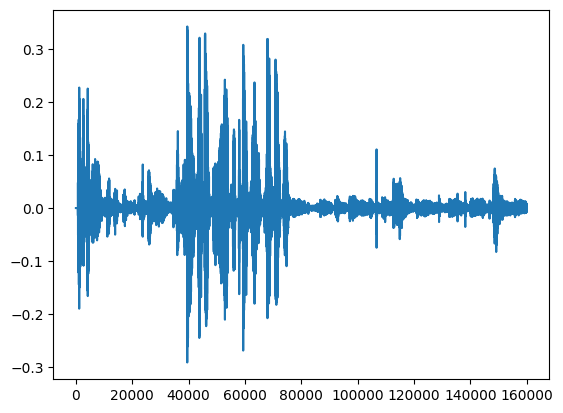

In [3]:
input_device_index = 28
speaker = p.get_device_info_by_index(input_device_index)

RATE=int(speaker['defaultSampleRate'])

stream = p.open(format=pyaudio.paInt16, channels=1, rate= RATE, input=True, input_device_index=input_device_index)
data = stream.read(RATE * 10, exception_on_overflow=False)  # Read a chunk of audio (1024 samples per chunk
audio_chunk = np.frombuffer(data, np.int16).flatten().astype(np.float32) / 32768.0

plt.plot(audio_chunk)
plt.show()

stream.stop_stream()
stream.close()

### If you were able to findout a speaker which shows some output then 'BRAVO' you can use that speaker's output as input to your whisper model for live transcriptions

## Understanding the nuts and bolts of WHISPER model

The Whisper model has mainly 2 parts, ```processor``` and ```model```. The processor is responsible for converting the audio signal to a **mel-spectogram**. 

- **mel-spectogram** is obtained by first taking the fourier transform of the input signal (Sort Time Fourier Trnasform (STFT)) abd then converting it to log-scale beacuse human eras work in that way.

- The model then takes this mel-spectogram as input and predicts the tokens said in the audio.

- Then we again use the ``processor``` to decode the tokenizers to a text representation.

In [4]:
device='cuda'
# Load model and processor
processor = WhisperProcessor.from_pretrained("openai/whisper-small")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to(device) #model.generation_config - to get list of languages
model.eval()
for p in model.parameters():
    p.requires_grad=False

WHISPER_RATE=16000 #WHISPER model is trained on 16KHZ data

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:

audio_chunk = resample(audio_chunk, int(len(audio_chunk) * WHISPER_RATE / RATE))  # Resample to 16kHz (it is needed as the WHISPER model is trained on 16KHZ data)
input_features = processor(audio_chunk, sampling_rate=WHISPER_RATE, return_tensors="pt",device=device).input_features

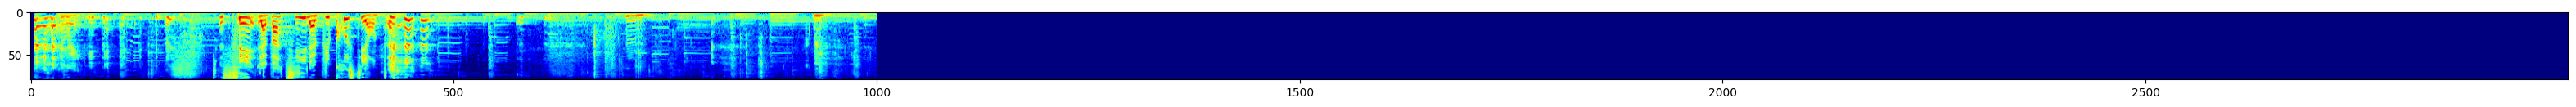

In [6]:
plt.figure(figsize=(40,40))
plt.imshow(input_features[0],cmap='jet')
plt.show()

In [7]:
forced_decoder_ids=None
# Generate token ids
with torch.no_grad():
    predicted_ids = model.generate(input_features.to(device), task='translate', language='French') 
# # Decode token ids to text
transcription = processor.batch_decode(predicted_ids, skip_special_tokens=False)

c:\Users\Asus\miniconda3\lib\site-packages\transformers\models\whisper\modeling_whisper.py:694: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [8]:
transcription

["<|startoftranscript|><|fr|><|translate|><|notimestamps|> It's the most crunchy part.<|endoftext|>"]

In [12]:

INPUT_DEVICE = {1:'microphone', 2:'speaker'}
""" for pc_speaker, go to the sound icon and right click-> choose sounds -> recordings -> choose streo Mix as default  """
INPUT_DEVICE_IDX = 2


device='cuda'
# Load model and processor
processor = WhisperProcessor.from_pretrained("openai/whisper-small")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to(device)
model.eval()
for p in model.parameters():
    p.requires_grad=False
# forced_decoder_ids = processor.get_decoder_prompt_ids(language="french", task="transcribe")#for french to french
forced_decoder_ids = processor.get_decoder_prompt_ids(language="french", task="translate")#for french to english
# forced_decoder_ids = None # for english to english



# Initialize PyAudio
p = pyaudio.PyAudio()

micro_phone = p.get_device_info_by_index(input_device_index)
print(f'The input device is {micro_phone}')

# Settings for recording audio
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = int(micro_phone['defaultSampleRate'] ) 
WHISPER_RATE = 16000# Whisper expects 16kHz input
TRANSCRIPTION_INTERVAL = 30  # Interval for transcription in seconds

# Open a stream to record audio

stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, input_device_index=micro_phone["index"])

print("Listening for audio... Speak now.")

audio_frames = np.array([], dtype=np.float32)  # Store raw audio frames


file_path = "transcriptions.txt"
if os.path.exists(file_path):
    os.remove(file_path)
# Open a text file to save the transcriptions
transcription_file = open(file_path, "a")


while True:
    try:

        # Read a chunk of audio
        data = stream.read(RATE*TRANSCRIPTION_INTERVAL, exception_on_overflow=False)  # Read a chunk of audio (1024 samples per chunk
        audio_chunk = np.frombuffer(data, np.int16).flatten().astype(np.float32) / 32768.0
        audio_chunk = resample(audio_chunk, int(len(audio_chunk) * WHISPER_RATE / RATE))  # Resample to 16kHz (it is needed as the WHISPER model is trained on 16KHZ data)


        audio_frames = np.append(audio_frames, audio_chunk)  # Save raw audio data for MP3 conversion

        # Start timing for processor
        start_processor_time = time.time()
        # Processing the audio chunk (processor time)
        input_features = processor(audio_chunk, sampling_rate=WHISPER_RATE, return_tensors="pt", device=device).input_features
        # Time taken by processor
        processor_duration = time.time() - start_processor_time
        # Start timing for model generation
        start_model_time = time.time()
        # Generate token ids (model time)
        with torch.no_grad():
            predicted_ids = model.generate(input_features.to(device), forced_decoder_ids=forced_decoder_ids)
        # Time taken by model
        model_duration = time.time() - start_model_time
        # Decode token ids to text
        transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)
        transcription_text = transcription[0]
        # Total time taken for translation
        translation_duration = processor_duration + model_duration

        # Save the transcription with a timestamp to the file
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        transcription_file.write(f"[{timestamp}] {transcription_text}\n")
        transcription_file.flush()  # Ensure it's written to the file immediately


        # Print the transcription
        print(f"Transcription ({processor_duration:0.3f}s)|({model_duration:0.3f}s): {transcription_text}")



    except KeyboardInterrupt:
        print("Stopped listening.")
        save_wave(audio_frames, rate=WHISPER_RATE)
        break

# Stop and close the stream
transcription_file.close()
stream.stop_stream()
stream.close()
p.terminate()



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


The input device is {'index': 28, 'structVersion': 2, 'name': 'Headset (realme Buds Wireless 3 Hands-Free AG Audio) [Loopback]', 'hostApi': 2, 'maxInputChannels': 1, 'maxOutputChannels': 0, 'defaultLowInputLatency': 0.003, 'defaultLowOutputLatency': 0.0, 'defaultHighInputLatency': 0.01, 'defaultHighOutputLatency': 0.0, 'defaultSampleRate': 16000.0, 'isLoopbackDevice': True}
Listening for audio... Speak now.
Transcription (0.204s)|(1.341s):  but the traditional version is really excellent and to finish one of my favorite cakes is the quatkaar so the quatkaar is a traditional cake like that, nature and it holds its name
Transcription (0.200s)|(2.028s):  4 ingredients at equal parts. It's 1 quarter of flour, 1 quarter of butter, 1 quarter of eggs and 1 quarter of milk. And it's done. The 4 quarter and it's excellent. So I have the impression that the 4 quarter is often the cake we eat at the school's carnival. Or events like that where there are groups of children, there is often someone 